<a href="https://colab.research.google.com/github/uakarsh/docformer/blob/master/examples/docformer_pl/token_cls/Token_ification_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## Installing the dependencies (might take some time)

%%capture
!pip install pytesseract
!sudo apt install tesseract-ocr
!pip install transformers
!pip install pytorch-lightning
!pip install einops
!pip install tqdm
!pip install 'Pillow==7.1.2'
!pip install datasets

UsageError: Line magic function `%%capture` not found.


In [3]:
# !git clone https://github.com/shabie/docformer.git

In [1]:
from datasets import load_dataset
from PIL import Image
import numpy as np

## Importing the libraries

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

import os
import numpy as np
import pandas as pd
from PIL import Image,ImageDraw

import torch
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

import math
import torch.nn.functional as F
from torch import Tensor

## Adding the path of docformer to system path
import sys
sys.path.append('./docformer/src/docformer/')

## Importing the functions from the DocFormer Repo
from modeling import DocFormerEncoder,ResNetFeatureExtractor,DocFormerEmbeddings,LanguageFeatureExtractor
from transformers import BertTokenizerFast

C:\Users\ivona\Desktop\MSc Thesis\semtabfact\semtabfact\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from utils import get_parent_directory_path

TSV_FOLDER =  get_parent_directory_path(1) + os.sep + "tsv"
train_ds =  pd.read_csv(os.path.normpath(TSV_FOLDER + os.sep + 'train_man_set.tsv'),
                           sep='\t', header=0)
val_ds = pd.read_csv(os.path.normpath(TSV_FOLDER + os.sep + 'val_man_set.tsv'),
                           sep='\t', header=0)

## Generating the dataset appropriate to the DocFormer Input

In [4]:
## Same as here: https://github.com/shabie/docformer/blob/master/src/docformer/dataset.py

def normalize_box(box, width, height, size=1000):
    """
    Takes a bounding box and normalizes it to a thousand pixels. If you notice it is
    just like calculating percentage except takes 1000 instead of 100.
    """
    return [
        int(size * (box[0] / width)),
        int(size * (box[1] / height)),
        int(size * (box[2] / width)),
        int(size * (box[3] / height)),
    ]

def resize_align_bbox(bbox, orig_w, orig_h, target_w, target_h):
    x_scale = target_w / orig_w
    y_scale = target_h / orig_h
    orig_left, orig_top, orig_right, orig_bottom = bbox
    x = int(np.round(orig_left * x_scale))
    y = int(np.round(orig_top * y_scale))
    xmax = int(np.round(orig_right * x_scale))
    ymax = int(np.round(orig_bottom * y_scale))
    return [x, y, xmax, ymax]


def get_tokens_with_boxes(unnormalized_word_boxes, list_of_words, token_label, tokenizer, pad_token_id = 0, pad_token_box = [0, 0, 0, 0], max_seq_len = 512, pad_token_class = 7):
    
    '''
    This function returns two items:
    1. unnormalized_token_boxes -> a list of len = max_seq_len, containing the boxes corresponding to the tokenized words, 
                                    one box might repeat as per the tokenization procedure
    2. tokenized_words -> tokenized words corresponding to the tokenizer and the list_of_words
    '''

    assert len(unnormalized_word_boxes) == len(list_of_words) == len(token_label), f"Length of Bounding box: {len(unnormalized_word_boxes)}, words: {len(list_of_words)}, token: {len(token_label)}"
    
    length_of_box = len(unnormalized_word_boxes)
    unnormalized_token_boxes = []
    tokenized_words = []
    final_token_label = []

    for box, word, token in zip(unnormalized_word_boxes, list_of_words, token_label):
      current_tokens = tokenizer(word, add_special_tokens = False).input_ids
      unnormalized_token_boxes.extend([box]*len(current_tokens))
      tokenized_words.extend(current_tokens)
      final_token_label.extend([token]*len(current_tokens))

    if len(unnormalized_token_boxes)<max_seq_len:
        unnormalized_token_boxes.extend([pad_token_box] * (max_seq_len-len(unnormalized_token_boxes)))
        
    if len(tokenized_words)< max_seq_len:
        tokenized_words.extend([pad_token_id]* (max_seq_len-len(tokenized_words)))

    if len(final_token_label)< max_seq_len:
        final_token_label.extend([pad_token_class]* (max_seq_len-len(final_token_label)))
        
    return unnormalized_token_boxes[:max_seq_len], tokenized_words[:max_seq_len], final_token_label[:max_seq_len]


def get_centroid(actual_bbox):
    centroid = []
    for i in actual_bbox:
        width = i[2] - i[0]
        height = i[3] - i[1]
        centroid.append([i[0] + width / 2, i[1] + height / 2])
    return centroid


def get_pad_token_id_start_index(words, encoding, tokenizer): 
#     assert len(words) < len(encoding["input_ids"])  This condition, was creating errors on some sample images
    for idx in range(len(encoding["input_ids"])):
        if encoding["input_ids"][idx] == tokenizer.pad_token_id:
            break
    return idx


def get_relative_distance(bboxes, centroids, pad_tokens_start_idx):

    a_rel_x = []
    a_rel_y = []

    for i in range(0, len(bboxes)-1):
        if i >= pad_tokens_start_idx:
            a_rel_x.append([0] * 8)
            a_rel_y.append([0] * 8)
            continue

        curr = bboxes[i]
        next = bboxes[i+1]

        a_rel_x.append(
            [
                curr[0],  # top left x
                curr[2],  # bottom right x
                curr[2] - curr[0],  # width
                next[0] - curr[0],  # diff top left x
                next[0] - curr[0],  # diff bottom left x
                next[2] - curr[2],  # diff top right x
                next[2] - curr[2],  # diff bottom right x
                centroids[i+1][0] - centroids[i][0],
            ]
        )

        a_rel_y.append(
            [
                curr[1],  # top left y
                curr[3],  # bottom right y
                curr[3] - curr[1],  # height
                next[1] - curr[1],  # diff top left y
                next[3] - curr[3],  # diff bottom left y
                next[1] - curr[1],  # diff top right y
                next[3] - curr[3],  # diff bottom right y
                centroids[i+1][1] - centroids[i][1],
            ]
        )

    # For the last word
    
    a_rel_x.append([0]*8)  
    a_rel_y.append([0]*8)

    return a_rel_x, a_rel_y

In [5]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [6]:
import torch
from torchvision.transforms import ToTensor
PAD_TOKEN_BOX = [0, 0, 0, 0]

def create_features(
        image,
        tokenizer,
        add_batch_dim=False,
        target_size=(512,384),  # This was the resolution used by the authors
        max_seq_length=512,
        bounding_box = None,
        words = None,
        token_labels = None
):

    # step 1: read original image and extract OCR entries
    original_image = image.convert("RGB")
    CLS_TOKEN_BOX = [0, 0, *original_image.size]    # Can be variable, but as per the paper, they have mentioned that it covers the whole image
    # step 2: resize image
    resized_image = original_image.resize(target_size)

    # step 3: tokenize words and get their bounding boxes (one word may split into multiple tokens), and accordingly their tokens
    unnormalized_token_boxes, tokenized_words,final_token_label = get_tokens_with_boxes(bounding_box, 
                                                     words, 
                                                     token_labels, 
                                                     tokenizer, 
                                                     pad_token_id = 0, 
                                                     pad_token_box = [0, 0, 0, 0], 
                                                     max_seq_len = 512, 
                                                     pad_token_class = 7)

    encoding = {}
    # step 5: add special tokens and truncate seq. to maximum length
    unnormalized_token_boxes = [CLS_TOKEN_BOX] + unnormalized_token_boxes[:-1]
    final_token_label = [7] + final_token_label[:-1]

    # add CLS token manually to avoid autom. addition of SEP too (as in the paper)
    encoding["input_ids"] = [tokenizer.cls_token_id] + tokenized_words[:-1]

    # step 6: Add bounding boxes to the encoding dict
    encoding["unnormalized_token_boxes"] = unnormalized_token_boxes
    # step 8: normalize the image
    encoding["resized_scaled_img"] = ToTensor()(resized_image)

    # step 10: rescale and align the bounding boxes to match the resized image size (typically 224x224)
    resized_and_aligned_bboxes = []

    for bbox in unnormalized_token_boxes:
        # performing the normalization of the bounding box
        resized_and_aligned_bboxes.append(resize_align_bbox(tuple(bbox), *original_image.size, *target_size))

    encoding["resized_and_aligned_bounding_boxes"] = resized_and_aligned_bboxes
    encoding['token_class'] = final_token_label

    # step 11: add the relative distances in the normalized grid
    bboxes_centroids = get_centroid(resized_and_aligned_bboxes)
    pad_token_start_index = get_pad_token_id_start_index(words, encoding, tokenizer)
    a_rel_x, a_rel_y = get_relative_distance(resized_and_aligned_bboxes, bboxes_centroids, pad_token_start_index)

    # step 12: convert all to tensors
    for k, v in encoding.items():
        encoding[k] = torch.as_tensor(encoding[k])

    encoding.update({
        "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
        "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),
        })

    keys = ['resized_scaled_img', 'x_features','y_features','input_ids','resized_and_aligned_bounding_boxes', 'token_class']
    
    final_encoding = {k:encoding[k] for k in keys}
    
    del encoding
    return final_encoding

In [11]:
encoding = create_features(
    image = sample,
    tokenizer = tokenizer,
    bounding_box = train_ds[0]['bboxes'],
    words = train_ds[0]['tokens'],
    token_labels = train_ds[0]['ner_tags']
)

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


In [12]:
for key in list(encoding.keys()):
  print_statement = '{0: <50}'.format(str(key) + " has a shape:")
  print(print_statement, encoding[key].shape)

resized_scaled_img has a shape:                    torch.Size([3, 384, 512])
x_features has a shape:                            torch.Size([512, 8])
y_features has a shape:                            torch.Size([512, 8])
input_ids has a shape:                             torch.Size([512])
resized_and_aligned_bounding_boxes has a shape:    torch.Size([512, 4])
token_class has a shape:                           torch.Size([512])


## Making the dataset

In [9]:
## Keys
train_ds[0].keys()

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image'])

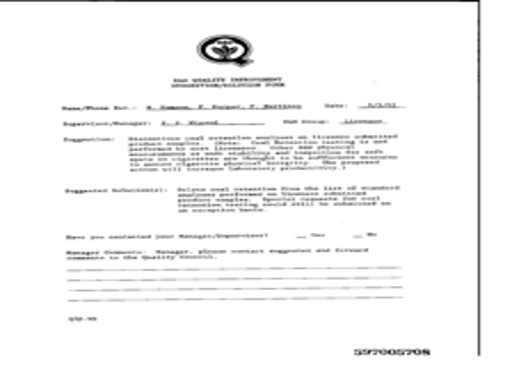

In [10]:
sample = np.array(train_ds[0]['image'])
sample = np.transpose(sample, (1, 2, 0)).astype(np.uint8)
sample = Image.fromarray(sample)

# Visualizing the resized image
target_size = (512, 384)
resize_img = sample.resize(target_size)
resize_img

In [13]:
## From here: https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv2/FUNSD/True_inference_with_LayoutLMv2ForTokenClassification_%2B_Gradio_demo.ipynb#scrollTo=eFgjNr9SNzzb

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

In [14]:
class DocumentDataset(Dataset):

  def __init__(self, ds, tokenizer, max_len = 512, target_size = (512, 384)):
    self.ds = ds
    self.target_size = target_size
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.target_size = target_size

  def __len__(self):
    return len(self.ds)

  def __getitem__(self, idx):

    ## Loading the file
    sample_entry = self.ds[idx]
    sample = np.array(sample_entry['image'])
    sample = np.transpose(sample, (1, 2, 0)).astype(np.uint8)
    sample = Image.fromarray(sample)

    true_boxes = [unnormalize_box(box, 224, 224) for idx, box in enumerate(sample_entry['bboxes'])]  ## 224, 224 -> image resized shape
    
    encoding = create_features(
        image = sample,
        tokenizer = self.tokenizer,
        bounding_box = true_boxes,
        words = sample_entry['tokens'],
        token_labels = sample_entry['ner_tags']
    )

    return encoding

In [15]:
train_dataset = DocumentDataset(train_ds, tokenizer)
val_dataset = DocumentDataset(val_ds, tokenizer)

In [16]:
def collate_fn(data_bunch):

  '''
  A function for the dataloader to return a batch dict of given keys

  data_bunch: List of dictionary
  '''

  dict_data_bunch = {}

  for i in data_bunch:
    for (key, value) in i.items():
      if key not in dict_data_bunch:
        dict_data_bunch[key] = []
      dict_data_bunch[key].append(value)

  for key in list(dict_data_bunch.keys()):
      dict_data_bunch[key] = torch.stack(dict_data_bunch[key], axis = 0)

  return dict_data_bunch

In [17]:
train_dl = DataLoader(train_dataset, batch_size = 4, collate_fn = collate_fn)
val_dl = DataLoader(val_dataset, batch_size = 4, collate_fn = collate_fn)

In [18]:
encoding = next(iter(train_dl))
for key in list(encoding.keys()):
  print_statement = '{0: <50}'.format(str(key) + " has a shape:")
  print(print_statement, encoding[key].shape)

resized_scaled_img has a shape:                    torch.Size([4, 3, 384, 512])
x_features has a shape:                            torch.Size([4, 512, 8])
y_features has a shape:                            torch.Size([4, 512, 8])
input_ids has a shape:                             torch.Size([4, 512])
resized_and_aligned_bounding_boxes has a shape:    torch.Size([4, 512, 4])
token_class has a shape:                           torch.Size([4, 512])


C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


## Defining the DataModule

In [19]:
import pytorch_lightning as pl

class DataModule(pl.LightningDataModule):

  def __init__(self, train_dataset, val_dataset,  batch_size = 2):

    super(DataModule, self).__init__()
    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    self.batch_size = batch_size

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, 
                      collate_fn = collate_fn, shuffle = True)
  
  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size,
                                  collate_fn = collate_fn, shuffle = False)

In [20]:
datamodule = DataModule(train_dataset, val_dataset)

## Modeling

In [21]:
## Setting some hyperparameters

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = {
  "coordinate_size": 96,              ## (768/8), 8 for each of the 8 coordinates of x, y
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "image_feature_pool_shape": [7, 7, 256],
  "intermediate_ff_size_factor": 4,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 512,
  "max_relative_positions": 8,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "shape_size": 96,
  "vocab_size": 30522,
  "layer_norm_eps": 1e-12,
  "classes": 2
}

In [22]:
class DocFormerForTokenCLS(nn.Module):
  
    def __init__(self, config):
      super(DocFormerForTokenCLS, self).__init__()

      self.resnet = ResNetFeatureExtractor()
      self.embeddings = DocFormerEmbeddings(config)
      self.lang_emb = LanguageFeatureExtractor()
      self.config = config
      self.dropout = nn.Dropout(config['hidden_dropout_prob'])
      self.linear_layer = nn.Linear(in_features = config['hidden_size'], out_features = config['classes'] + 1)
      self.encoder = DocFormerEncoder(config)

    def forward(self, batch_dict):

      x_feat = batch_dict['x_features']
      y_feat = batch_dict['y_features']

      token = batch_dict['input_ids']
      img = batch_dict['resized_scaled_img']

      v_bar_s, t_bar_s = self.embeddings(x_feat,y_feat)
      v_bar = self.resnet(img)
      t_bar = self.lang_emb(token)
      out = self.encoder(t_bar,v_bar,t_bar_s,v_bar_s)
      out = self.linear_layer(out)

      return out


In [23]:
## Defining pytorch lightning model
from sklearn.metrics import accuracy_score


class DocFormer(pl.LightningModule):

  def __init__(self, config , lr = 1e-3):
    super(DocFormer, self).__init__()
    
    self.config = config
    self.save_hyperparameters()
    self.docformer = DocFormerForTokenCLS(config)
    self.training_losses = []
    self.validation_losses = []


  def calculate_metrics(self, prediction, labels):

    ## Calculate the accuracy score between the prediction and ground label for a batch, with considering the pad sequence
    batch_size = len(prediction)
    ac_score = 0

    for (pred, gt) in zip(prediction, labels):
      ac_score+= accuracy_score(pred.cpu(), gt.cpu())
    ac_score = ac_score/batch_size
    return ac_score


  def forward(self, batch_dict):
    logits = self.docformer(batch_dict)
    return logits

  def training_step(self, batch, batch_idx):
    logits = self.forward(batch)

    ## https://discuss.huggingface.co/t/bertformaskedlm-s-loss-and-scores-how-the-loss-is-computed/607/2
    loss = nn.CrossEntropyLoss()(logits.view(-1,config['classes'] + 1), batch['token_class'].view(-1))
    _, preds = torch.max(logits, dim = -1)

    ## Calculating the accuracy score
    train_acc = self.calculate_metrics(preds, batch['token_class'])
    train_acc = torch.tensor(train_acc)

    ## Logging
    self.log('train_ce_loss', loss,prog_bar = True)
    self.log('train_acc', train_acc, prog_bar = True)
    self.training_losses.append(loss.item())

    return loss
  
  def validation_step(self, batch, batch_idx):
    logits = self.forward(batch)
    loss = nn.CrossEntropyLoss()(logits.view(-1, self.config['classes'] + 1), batch['token_class'].view(-1))
    _, preds = torch.max(logits, dim = -1)

    ## Validation Accuracy
    val_acc = self.calculate_metrics(preds.cpu(), batch['token_class'].cpu())
    val_acc = torch.tensor(val_acc)

    ## Logging
    self.log('val_ce_loss', loss, prog_bar = True)
    self.log('val_acc', val_acc, prog_bar = True)
    self.validation_losses.append(loss.item())

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr = self.hparams['lr'])

  def on_train_epoch_end(self):
    train_loss_mean = np.mean(self.training_losses)
    self.logger.experiment.add_scalar('training_loss', train_loss_mean, global_step=self.current_epoch)
    self.training_losses = []  # reset for next epoch

  def on_validation_epoch_end(self):
    val_loss_mean = np.mean(self.training_losses)
    self.logger.experiment.add_scalar('validation_loss', val_loss_mean, global_step=self.current_epoch)
    self.validation_losses = []  # reset for next epoch

In [24]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

def main():
    datamodule = DataModule(train_dataset, val_dataset)
    docformer = DocFormer(config)

    checkpoint_callback = ModelCheckpoint(
        dirpath="./models", monitor="val_ce_loss", mode="min"
    )
    early_stopping_callback = EarlyStopping(
        monitor="val_ce_loss", patience=3, verbose=True, mode="min"
    )

    ## https://www.tutorialexample.com/implement-reproducibility-in-pytorch-lightning-pytorch-lightning-tutorial/
    pl.seed_everything(42, workers=True)
    trainer = pl.Trainer(
        default_root_dir="logs",
        max_epochs=2,
        fast_dev_run=False,
        logger=pl.loggers.TensorBoardLogger("logs/", name="semtab_dataset", version=1),
        callbacks=[checkpoint_callback, early_stopping_callback],
        deterministic=True
    )
    trainer.fit(docformer, datamodule)

In [ ]:
# import tensorboard
if __name__ == "__main__":
    main()

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:08<00:08,  8.33s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:   0%|          | 0/75 [00:00<?, ?it/s]                            

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:   1%|▏         | 1/75 [00:58<1:12:43, 58.97s/it, v_num=1, train_ce_loss=41.90, train_acc=0.0488]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:   3%|▎         | 2/75 [02:19<1:24:37, 69.56s/it, v_num=1, train_ce_loss=27.60, train_acc=0.738] 

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:   4%|▍         | 3/75 [03:31<1:24:47, 70.66s/it, v_num=1, train_ce_loss=32.60, train_acc=0.431]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:   5%|▌         | 4/75 [04:36<1:21:40, 69.01s/it, v_num=1, train_ce_loss=15.30, train_acc=0.709]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:   7%|▋         | 5/75 [05:39<1:19:07, 67.82s/it, v_num=1, train_ce_loss=22.00, train_acc=0.604]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:   8%|▊         | 6/75 [06:54<1:19:21, 69.01s/it, v_num=1, train_ce_loss=19.50, train_acc=0.697]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:   9%|▉         | 7/75 [07:58<1:17:28, 68.36s/it, v_num=1, train_ce_loss=22.30, train_acc=0.660]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  11%|█         | 8/75 [09:03<1:15:49, 67.90s/it, v_num=1, train_ce_loss=35.60, train_acc=0.390]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  12%|█▏        | 9/75 [10:14<1:15:04, 68.26s/it, v_num=1, train_ce_loss=21.90, train_acc=0.467]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  13%|█▎        | 10/75 [11:20<1:13:42, 68.04s/it, v_num=1, train_ce_loss=15.50, train_acc=0.596]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  15%|█▍        | 11/75 [12:23<1:12:05, 67.59s/it, v_num=1, train_ce_loss=10.80, train_acc=0.690]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  16%|█▌        | 12/75 [13:25<1:10:28, 67.11s/it, v_num=1, train_ce_loss=6.860, train_acc=0.707]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  17%|█▋        | 13/75 [14:32<1:09:19, 67.09s/it, v_num=1, train_ce_loss=9.690, train_acc=0.581]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  19%|█▊        | 14/75 [15:38<1:08:10, 67.06s/it, v_num=1, train_ce_loss=8.810, train_acc=0.603]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  20%|██        | 15/75 [16:51<1:07:25, 67.43s/it, v_num=1, train_ce_loss=7.420, train_acc=0.747]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  21%|██▏       | 16/75 [17:59<1:06:20, 67.47s/it, v_num=1, train_ce_loss=8.200, train_acc=0.580]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  23%|██▎       | 17/75 [19:07<1:05:16, 67.52s/it, v_num=1, train_ce_loss=14.20, train_acc=0.318]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  24%|██▍       | 18/75 [20:12<1:04:00, 67.38s/it, v_num=1, train_ce_loss=10.40, train_acc=0.634]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  25%|██▌       | 19/75 [21:19<1:02:50, 67.32s/it, v_num=1, train_ce_loss=6.030, train_acc=0.788]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  27%|██▋       | 20/75 [22:25<1:01:40, 67.28s/it, v_num=1, train_ce_loss=10.80, train_acc=0.633]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  28%|██▊       | 21/75 [23:24<1:00:10, 66.87s/it, v_num=1, train_ce_loss=8.240, train_acc=0.637]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  29%|██▉       | 22/75 [24:23<58:46, 66.54s/it, v_num=1, train_ce_loss=6.970, train_acc=0.690]  

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  31%|███       | 23/75 [25:22<57:22, 66.19s/it, v_num=1, train_ce_loss=6.030, train_acc=0.716]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  32%|███▏      | 24/75 [26:25<56:09, 66.06s/it, v_num=1, train_ce_loss=6.820, train_acc=0.679]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  33%|███▎      | 25/75 [27:32<55:04, 66.08s/it, v_num=1, train_ce_loss=8.500, train_acc=0.531]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  35%|███▍      | 26/75 [28:50<54:20, 66.55s/it, v_num=1, train_ce_loss=5.930, train_acc=0.675]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  36%|███▌      | 27/75 [29:59<53:19, 66.65s/it, v_num=1, train_ce_loss=4.720, train_acc=0.692]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  37%|███▋      | 28/75 [31:12<52:23, 66.89s/it, v_num=1, train_ce_loss=6.300, train_acc=0.606]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  39%|███▊      | 29/75 [32:18<51:15, 66.86s/it, v_num=1, train_ce_loss=6.830, train_acc=0.661]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  40%|████      | 30/75 [33:27<50:11, 66.93s/it, v_num=1, train_ce_loss=5.590, train_acc=0.699]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  41%|████▏     | 31/75 [34:50<49:27, 67.44s/it, v_num=1, train_ce_loss=5.480, train_acc=0.624]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  43%|████▎     | 32/75 [35:59<48:21, 67.47s/it, v_num=1, train_ce_loss=3.940, train_acc=0.769]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  44%|████▍     | 33/75 [37:08<47:16, 67.52s/it, v_num=1, train_ce_loss=3.090, train_acc=0.816]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  45%|████▌     | 34/75 [38:10<46:02, 67.37s/it, v_num=1, train_ce_loss=4.210, train_acc=0.675]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  47%|████▋     | 35/75 [39:13<44:50, 67.26s/it, v_num=1, train_ce_loss=3.460, train_acc=0.779]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  48%|████▊     | 36/75 [40:15<43:36, 67.10s/it, v_num=1, train_ce_loss=4.940, train_acc=0.781]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  49%|████▉     | 37/75 [41:18<42:25, 66.98s/it, v_num=1, train_ce_loss=4.180, train_acc=0.729]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  51%|█████     | 38/75 [42:04<40:58, 66.44s/it, v_num=1, train_ce_loss=3.590, train_acc=0.688]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  52%|█████▏    | 39/75 [43:07<39:48, 66.35s/it, v_num=1, train_ce_loss=4.500, train_acc=0.649]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  53%|█████▎    | 40/75 [44:25<38:52, 66.63s/it, v_num=1, train_ce_loss=5.680, train_acc=0.555]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  55%|█████▍    | 41/75 [45:48<37:59, 67.05s/it, v_num=1, train_ce_loss=6.090, train_acc=0.540]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  56%|█████▌    | 42/75 [46:51<36:48, 66.93s/it, v_num=1, train_ce_loss=2.300, train_acc=0.774]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  57%|█████▋    | 43/75 [47:49<35:35, 66.74s/it, v_num=1, train_ce_loss=2.710, train_acc=0.762]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  59%|█████▊    | 44/75 [48:48<34:23, 66.55s/it, v_num=1, train_ce_loss=2.710, train_acc=0.768]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  60%|██████    | 45/75 [49:48<33:12, 66.42s/it, v_num=1, train_ce_loss=4.590, train_acc=0.648]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  61%|██████▏   | 46/75 [50:58<32:07, 66.48s/it, v_num=1, train_ce_loss=2.700, train_acc=0.746]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  63%|██████▎   | 47/75 [52:04<31:01, 66.47s/it, v_num=1, train_ce_loss=2.990, train_acc=0.725]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  64%|██████▍   | 48/75 [53:09<29:54, 66.45s/it, v_num=1, train_ce_loss=2.430, train_acc=0.789]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  65%|██████▌   | 49/75 [54:15<28:47, 66.43s/it, v_num=1, train_ce_loss=4.230, train_acc=0.657]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  67%|██████▋   | 50/75 [55:18<27:39, 66.36s/it, v_num=1, train_ce_loss=4.620, train_acc=0.657]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  68%|██████▊   | 51/75 [56:25<26:33, 66.39s/it, v_num=1, train_ce_loss=2.090, train_acc=0.807]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  69%|██████▉   | 52/75 [57:32<25:26, 66.39s/it, v_num=1, train_ce_loss=3.110, train_acc=0.703]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  71%|███████   | 53/75 [58:40<24:21, 66.42s/it, v_num=1, train_ce_loss=3.550, train_acc=0.738]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  72%|███████▏  | 54/75 [59:41<23:12, 66.32s/it, v_num=1, train_ce_loss=4.250, train_acc=0.609]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  73%|███████▎  | 55/75 [1:00:46<22:05, 66.30s/it, v_num=1, train_ce_loss=3.890, train_acc=0.587]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  75%|███████▍  | 56/75 [1:01:59<21:02, 66.43s/it, v_num=1, train_ce_loss=1.980, train_acc=0.793]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  76%|███████▌  | 57/75 [1:03:22<20:00, 66.71s/it, v_num=1, train_ce_loss=4.490, train_acc=0.581]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  77%|███████▋  | 58/75 [1:04:25<18:52, 66.64s/it, v_num=1, train_ce_loss=2.950, train_acc=0.711]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  79%|███████▊  | 59/75 [1:05:35<17:47, 66.70s/it, v_num=1, train_ce_loss=2.480, train_acc=0.752]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  80%|████████  | 60/75 [1:06:36<16:39, 66.61s/it, v_num=1, train_ce_loss=2.870, train_acc=0.770]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  81%|████████▏ | 61/75 [1:07:42<15:32, 66.59s/it, v_num=1, train_ce_loss=3.010, train_acc=0.675]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  83%|████████▎ | 62/75 [1:08:58<14:27, 66.76s/it, v_num=1, train_ce_loss=4.620, train_acc=0.544]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  84%|████████▍ | 63/75 [1:10:19<13:23, 66.98s/it, v_num=1, train_ce_loss=2.000, train_acc=0.744]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  85%|████████▌ | 64/75 [1:11:27<12:16, 67.00s/it, v_num=1, train_ce_loss=2.900, train_acc=0.686]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  87%|████████▋ | 65/75 [1:12:40<11:10, 67.09s/it, v_num=1, train_ce_loss=2.710, train_acc=0.707]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  88%|████████▊ | 66/75 [1:13:49<10:03, 67.11s/it, v_num=1, train_ce_loss=2.640, train_acc=0.749]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  89%|████████▉ | 67/75 [1:14:45<08:55, 66.95s/it, v_num=1, train_ce_loss=2.360, train_acc=0.730]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  91%|█████████ | 68/75 [1:15:55<07:48, 67.00s/it, v_num=1, train_ce_loss=2.630, train_acc=0.719]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  92%|█████████▏| 69/75 [1:17:02<06:41, 66.99s/it, v_num=1, train_ce_loss=4.890, train_acc=0.441]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  93%|█████████▎| 70/75 [1:18:12<05:35, 67.03s/it, v_num=1, train_ce_loss=2.250, train_acc=0.736]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  95%|█████████▍| 71/75 [1:19:23<04:28, 67.10s/it, v_num=1, train_ce_loss=3.620, train_acc=0.671]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  96%|█████████▌| 72/75 [1:20:22<03:20, 66.97s/it, v_num=1, train_ce_loss=2.680, train_acc=0.707]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  97%|█████████▋| 73/75 [1:21:28<02:13, 66.97s/it, v_num=1, train_ce_loss=1.800, train_acc=0.777]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0:  99%|█████████▊| 74/75 [1:22:30<01:06, 66.90s/it, v_num=1, train_ce_loss=2.760, train_acc=0.707]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 0: 100%|██████████| 75/75 [1:23:12<00:00, 66.57s/it, v_num=1, train_ce_loss=3.520, train_acc=0.703]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:   4%|▍         | 1/25 [00:12<05:02, 12.62s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:   8%|▊         | 2/25 [00:23<04:33, 11.87s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  12%|█▏        | 3/25 [00:37<04:37, 12.63s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  16%|█▌        | 4/25 [00:47<04:10, 11.95s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  20%|██        | 5/25 [00:56<03:45, 11.29s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  24%|██▍       | 6/25 [01:04<03:24, 10.79s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  28%|██▊       | 7/25 [01:13<03:08, 10.49s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  32%|███▏      | 8/25 [01:24<02:59, 10.55s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  36%|███▌      | 9/25 [01:33<02:45, 10.34s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  40%|████      | 10/25 [01:41<02:32, 10.14s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  44%|████▍     | 11/25 [01:50<02:20, 10.02s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  48%|████▊     | 12/25 [02:00<02:10, 10.05s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  52%|█████▏    | 13/25 [02:09<01:59,  9.93s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  56%|█████▌    | 14/25 [02:17<01:48,  9.83s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  60%|██████    | 15/25 [02:25<01:36,  9.69s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  64%|██████▍   | 16/25 [02:33<01:26,  9.59s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  68%|██████▊   | 17/25 [02:40<01:15,  9.47s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  72%|███████▏  | 18/25 [02:48<01:05,  9.36s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  76%|███████▌  | 19/25 [02:56<00:55,  9.27s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  80%|████████  | 20/25 [03:03<00:45,  9.19s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  84%|████████▍ | 21/25 [03:11<00:36,  9.13s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  88%|████████▊ | 22/25 [03:19<00:27,  9.08s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  92%|█████████▏| 23/25 [03:27<00:18,  9.04s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Validation DataLoader 0:  96%|█████████▌| 24/25 [03:35<00:08,  8.99s/it]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),



Epoch 0: 100%|██████████| 75/75 [1:26:56<00:00, 69.55s/it, v_num=1, train_ce_loss=3.520, train_acc=0.703, val_ce_loss=3.070, val_acc=0.646]

Metric val_ce_loss improved. New best score: 3.069


Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s, v_num=1, train_ce_loss=3.520, train_acc=0.703, val_ce_loss=3.070, val_acc=0.646]           

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:   1%|▏         | 1/75 [00:54<1:07:02, 54.35s/it, v_num=1, train_ce_loss=2.020, train_acc=0.771, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:   3%|▎         | 2/75 [01:59<1:12:40, 59.73s/it, v_num=1, train_ce_loss=3.610, train_acc=0.601, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:   4%|▍         | 3/75 [03:09<1:15:55, 63.27s/it, v_num=1, train_ce_loss=1.750, train_acc=0.839, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:   5%|▌         | 4/75 [04:09<1:13:55, 62.47s/it, v_num=1, train_ce_loss=2.330, train_acc=0.734, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:   7%|▋         | 5/75 [05:25<1:15:56, 65.09s/it, v_num=1, train_ce_loss=3.400, train_acc=0.720, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:   8%|▊         | 6/75 [06:18<1:12:27, 63.01s/it, v_num=1, train_ce_loss=1.380, train_acc=0.852, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:   9%|▉         | 7/75 [07:18<1:11:04, 62.71s/it, v_num=1, train_ce_loss=3.880, train_acc=0.632, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  11%|█         | 8/75 [08:21<1:09:55, 62.63s/it, v_num=1, train_ce_loss=1.540, train_acc=0.797, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  12%|█▏        | 9/75 [09:47<1:11:51, 65.32s/it, v_num=1, train_ce_loss=1.320, train_acc=0.823, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  13%|█▎        | 10/75 [11:03<1:11:55, 66.39s/it, v_num=1, train_ce_loss=2.380, train_acc=0.695, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  15%|█▍        | 11/75 [12:03<1:10:10, 65.79s/it, v_num=1, train_ce_loss=2.230, train_acc=0.801, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  16%|█▌        | 12/75 [13:15<1:09:38, 66.33s/it, v_num=1, train_ce_loss=2.190, train_acc=0.730, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  17%|█▋        | 13/75 [14:16<1:08:03, 65.86s/it, v_num=1, train_ce_loss=1.430, train_acc=0.800, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  19%|█▊        | 14/75 [15:16<1:06:35, 65.49s/it, v_num=1, train_ce_loss=1.490, train_acc=0.821, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  20%|██        | 15/75 [16:17<1:05:10, 65.18s/it, v_num=1, train_ce_loss=1.650, train_acc=0.791, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  21%|██▏       | 16/75 [17:25<1:04:14, 65.34s/it, v_num=1, train_ce_loss=3.360, train_acc=0.646, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  23%|██▎       | 17/75 [18:38<1:03:35, 65.79s/it, v_num=1, train_ce_loss=2.190, train_acc=0.735, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  24%|██▍       | 18/75 [20:10<1:03:53, 67.25s/it, v_num=1, train_ce_loss=1.290, train_acc=0.790, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  25%|██▌       | 19/75 [21:04<1:02:05, 66.53s/it, v_num=1, train_ce_loss=2.030, train_acc=0.757, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  27%|██▋       | 20/75 [22:10<1:01:00, 66.55s/it, v_num=1, train_ce_loss=2.750, train_acc=0.611, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  28%|██▊       | 21/75 [23:11<59:37, 66.26s/it, v_num=1, train_ce_loss=3.380, train_acc=0.536, val_ce_loss=3.070, val_acc=0.646]  

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  29%|██▉       | 22/75 [24:07<58:07, 65.80s/it, v_num=1, train_ce_loss=1.700, train_acc=0.795, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  31%|███       | 23/75 [25:12<56:59, 65.77s/it, v_num=1, train_ce_loss=2.270, train_acc=0.781, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  32%|███▏      | 24/75 [26:42<56:44, 66.75s/it, v_num=1, train_ce_loss=3.490, train_acc=0.664, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  33%|███▎      | 25/75 [28:17<56:34, 67.89s/it, v_num=1, train_ce_loss=2.470, train_acc=0.817, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  35%|███▍      | 26/75 [29:44<56:03, 68.65s/it, v_num=1, train_ce_loss=4.150, train_acc=0.619, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  36%|███▌      | 27/75 [31:15<55:34, 69.47s/it, v_num=1, train_ce_loss=3.630, train_acc=0.594, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  37%|███▋      | 28/75 [32:44<54:57, 70.17s/it, v_num=1, train_ce_loss=2.480, train_acc=0.671, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  39%|███▊      | 29/75 [34:18<54:24, 70.97s/it, v_num=1, train_ce_loss=3.510, train_acc=0.628, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  40%|████      | 30/75 [35:48<53:42, 71.62s/it, v_num=1, train_ce_loss=2.730, train_acc=0.697, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  41%|████▏     | 31/75 [37:26<53:08, 72.47s/it, v_num=1, train_ce_loss=3.440, train_acc=0.605, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  43%|████▎     | 32/75 [39:06<52:32, 73.32s/it, v_num=1, train_ce_loss=1.610, train_acc=0.816, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  44%|████▍     | 33/75 [40:38<51:43, 73.89s/it, v_num=1, train_ce_loss=1.330, train_acc=0.847, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  45%|████▌     | 34/75 [42:07<50:47, 74.33s/it, v_num=1, train_ce_loss=4.530, train_acc=0.607, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  47%|████▋     | 35/75 [43:40<49:55, 74.88s/it, v_num=1, train_ce_loss=1.520, train_acc=0.813, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  48%|████▊     | 36/75 [45:33<49:20, 75.92s/it, v_num=1, train_ce_loss=4.930, train_acc=0.538, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  49%|████▉     | 37/75 [47:09<48:25, 76.46s/it, v_num=1, train_ce_loss=3.130, train_acc=0.646, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  51%|█████     | 38/75 [48:03<46:47, 75.89s/it, v_num=1, train_ce_loss=2.200, train_acc=0.774, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  52%|█████▏    | 39/75 [49:09<45:22, 75.63s/it, v_num=1, train_ce_loss=0.888, train_acc=0.877, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  53%|█████▎    | 40/75 [50:13<43:57, 75.35s/it, v_num=1, train_ce_loss=4.830, train_acc=0.590, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  55%|█████▍    | 41/75 [51:16<42:31, 75.04s/it, v_num=1, train_ce_loss=1.650, train_acc=0.801, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  56%|█████▌    | 42/75 [51:56<40:48, 74.20s/it, v_num=1, train_ce_loss=3.060, train_acc=0.651, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  57%|█████▋    | 43/75 [52:56<39:24, 73.88s/it, v_num=1, train_ce_loss=2.210, train_acc=0.755, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  59%|█████▊    | 44/75 [53:56<38:00, 73.57s/it, v_num=1, train_ce_loss=1.360, train_acc=0.836, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  60%|██████    | 45/75 [54:56<36:37, 73.27s/it, v_num=1, train_ce_loss=4.120, train_acc=0.538, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  61%|██████▏   | 46/75 [55:58<35:17, 73.00s/it, v_num=1, train_ce_loss=2.300, train_acc=0.711, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  63%|██████▎   | 47/75 [56:57<33:55, 72.71s/it, v_num=1, train_ce_loss=2.320, train_acc=0.708, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  64%|██████▍   | 48/75 [57:56<32:35, 72.42s/it, v_num=1, train_ce_loss=2.170, train_acc=0.732, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  65%|██████▌   | 49/75 [58:56<31:16, 72.17s/it, v_num=1, train_ce_loss=3.110, train_acc=0.719, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  67%|██████▋   | 50/75 [59:55<29:57, 71.92s/it, v_num=1, train_ce_loss=2.330, train_acc=0.748, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  68%|██████▊   | 51/75 [1:00:56<28:40, 71.69s/it, v_num=1, train_ce_loss=2.760, train_acc=0.687, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  69%|██████▉   | 52/75 [1:01:55<27:23, 71.45s/it, v_num=1, train_ce_loss=2.290, train_acc=0.722, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  71%|███████   | 53/75 [1:02:55<26:07, 71.23s/it, v_num=1, train_ce_loss=0.911, train_acc=0.841, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  72%|███████▏  | 54/75 [1:03:55<24:51, 71.03s/it, v_num=1, train_ce_loss=1.620, train_acc=0.817, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  73%|███████▎  | 55/75 [1:04:58<23:37, 70.88s/it, v_num=1, train_ce_loss=1.980, train_acc=0.733, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  75%|███████▍  | 56/75 [1:05:57<22:22, 70.67s/it, v_num=1, train_ce_loss=1.690, train_acc=0.771, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),


Epoch 1:  76%|███████▌  | 57/75 [1:06:49<21:06, 70.35s/it, v_num=1, train_ce_loss=2.350, train_acc=0.711, val_ce_loss=3.070, val_acc=0.646]

C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:65: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "x_features": torch.as_tensor(a_rel_x, dtype=torch.int32),
C:\Users\ivona\AppData\Local\Temp\ipykernel_25332\1555465634.py:66: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "y_features": torch.as_tensor(a_rel_y, dtype=torch.int32),
